##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [4]:
df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [6]:
df.values.shape

(275, 7)

## Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
#to print the first 10 rows in the dataframe
df.head(10)

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


*Latitude and Longitude: These columns represent the geographical coordinates (location) of the incident.
*Hour of the day: This column indicates the hour of the day when the incident occurred.
*Day of the week: This column represents the day of the week when the incident occurred.
*Area-of-command code: This column is related to the police designation of the bureau of the operation.
*Classification code for the crime committed: This column specifies the type or classification of the crime committed.
*Number of persons involved in the accident: This is the target variable that we want to predict which represents the count of individuals involved in the incident

Inputs:1)Latitude and Longitude
       2)Hour of the day
       3)Day of the week
       4)Area-of-command code
       5)Classification code for the crime committed
Output:Number of persons involved in the crime

In [8]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


#Range of values:Based on the above values,
X====>Max=-114.625570 ; Min=-116.000000
Y====>Max=37.000000 ; Min=-35.068419
Area_Command======>Max=11.000000 ; Min=0.000000
NIBRSOffenseCode====>Max=2.000000 ; Min=0.000000
DayOfWeek====>Max=6.000000 ; Min=0.000000
Time====>Max=23.000000 ; Min=0.000000
VictimCount====>Max=6.000000 ; Min=0.000000

The range of the values for each column are not too wide apart and hence no scaling would be required.
However, there are some categorical data like Area_Command,which might need encoding techniques like one-hot encoding.
Since there are no none values in the dataset, we need not remove any rows or columns from the dataset.

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [9]:
# Spliting the dataset into training and testing sets, e.g., 80% for training, 20% for testing
train_ratio = 0.8
train_size = int(train_ratio * len(df))
test_size = len(df) - train_size
train_data, test_data = df[:train_size], df[train_size:]

# Defining a custom PyTorch Dataset class to handle your data
class CustomisedDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        x = sample[:-1] 
        y = sample[-1]
        return x, y

# Defining batch size
size_of_batch = 64

# Creating DataLoader objects for training and testing
train_dataset = CustomisedDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=size_of_batch, shuffle=True)

test_dataset = CustomisedDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=size_of_batch, shuffle=False)

# Verify the shape of data by iterating over the DataLoader
for batch in train_loader:
    inputs, targets = batch
    print("Shape of the Input batch:", inputs.shape)
    print("Shape of the Target batch:", targets.shape)
    break


Shape of the Input batch: torch.Size([64, 6])
Shape of the Target batch: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

1)Loss Function: For a regression task, Mean Squared Error (MSE) is a commonly used loss function as it measures the 
average squared difference between the predicted and actual values. So, for this task, we can use the MSE loss.

2)Output Size: Since we are predicting a single real number (the number of crime victims), the size of the predicted output should be 1.

3)Choice of architecture:The number of layers and hidden units in each layer is a hyperparameter and can be adjusted based on experimentation.We can start with a few hidden layers like 2 or 3 and a moderate number of hidden units like 64 in each layer. Based on the acheived accuracy, we can change the layers and hidden units to achieve a better model.

4)Optimizer and Learning Rate: A commonly used optimizer for training neural networks is Stochastic Gradient Descent (SGD),but in the model that we are building we can take Adam as it is easier to handle 'Nan' losses which I faced when training the model with SGD optimizer and we can choose an appropriate learning rate,like 0.01. We can adjust the learning rate  too during training based on accuracy.

In [10]:
import torch.nn as nn
import torch.optim as optim

#Building neural network architecture
class RegressionCrimePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionCrimePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Defining the model, loss function, and optimizer
input_size = len(train_dataset[0][0])
output_size = 1 
hidden_size = 64
regressionModel = RegressionCrimePredictor(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(regressionModel.parameters(), lr=0.01)

# Training loop
num_of_epochs = 30
for epoch in range(num_of_epochs):
    regressionModel.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = regressionModel(inputs.float())
        loss = criterion(outputs, targets.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_of_epochs}] - Loss: {average_loss:.4f}")

# Testing the model
regressionModel.eval()
total_mse = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = regressionModel(inputs.float())
        mse = criterion(outputs, targets.float().view(-1, 1))
        total_mse += mse.item()
    average_mse = total_mse / len(test_loader)
    print(f"Test MSE: {average_mse:.4f}")

Epoch [1/30] - Loss: 40.5226
Epoch [2/30] - Loss: 23.1628
Epoch [3/30] - Loss: 4.9860
Epoch [4/30] - Loss: 3.4463
Epoch [5/30] - Loss: 1.1454
Epoch [6/30] - Loss: 1.8623
Epoch [7/30] - Loss: 1.1829
Epoch [8/30] - Loss: 1.1920
Epoch [9/30] - Loss: 0.9359
Epoch [10/30] - Loss: 0.9895
Epoch [11/30] - Loss: 0.8870
Epoch [12/30] - Loss: 0.7920
Epoch [13/30] - Loss: 0.8193
Epoch [14/30] - Loss: 0.8023
Epoch [15/30] - Loss: 0.7746
Epoch [16/30] - Loss: 0.8576
Epoch [17/30] - Loss: 0.8587
Epoch [18/30] - Loss: 0.7776
Epoch [19/30] - Loss: 0.8264
Epoch [20/30] - Loss: 0.9212
Epoch [21/30] - Loss: 0.7534
Epoch [22/30] - Loss: 0.7472
Epoch [23/30] - Loss: 0.8539
Epoch [24/30] - Loss: 0.8407
Epoch [25/30] - Loss: 0.8372
Epoch [26/30] - Loss: 0.8365
Epoch [27/30] - Loss: 0.8032
Epoch [28/30] - Loss: 0.8257
Epoch [29/30] - Loss: 0.8244
Epoch [30/30] - Loss: 0.8419
Test MSE: 1.5162


*Optimizer change:When using SDG as optimizer, we get Nan as loss. Using Adam as optimizer has solved the issue.
*Learning rate change:Changing the learning rate to 0.001 from 0.01 has incresed the average MSE by a little percentage.
*Changing number of epochs gradually lead to a decrease in loss and improve in accuracy.However, with a gicen structure, there is not much change in the improvement of accuracy after certain epochs like 30 in my case.
*Changing the number of hidden units: While testing with different values of hidden units keeping the remaning values unchanged, having 64 units have given lowest loss and better accuracy.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

Number of classes on the o/p data: The size of the predicted output should match the number of different classes that are 
                                  present in the CrimeStats Dataset. And this can be obtained by inspecting the dataset to 
                                  find unique class labels in the "number of crime victims" column.
Architecture:The architecture should be different from the regression case.We have to use a different output layer with a                    softmax activation to produce class probabilities. The choice of architecture, including the number of layers and                hidden units, can be updated based on the accuracy of the model after testing it everytime.
Loss function:For a classification problem, we should use a categorical cross-entropy loss function. Hence, we will be using                   nn.CrossEntropyLoss for this purpose.

In [11]:
# Define your neural network architecture
class ClassificationCrimeClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ClassificationCrimeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Determine the number of classes based on your data
num_of_classes = len(df['VictimCount'].unique())

# Define the model, loss function, and optimizer
input_size = len(train_dataset[0][0])  # Input features
hidden_size = 64  # Experiment with different values
classifierModel = ClassificationCrimeClassifier(input_size, hidden_size, num_of_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifierModel.parameters(), lr=0.01)

# Training loop
num_epochs = 20 # Experiment with different numbers of epochs
for epoch in range(num_epochs):
    classifierModel.train()
    total_loss = 0.0
    correct_predictions = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = classifierModel(inputs.float())
        loss = criterion(outputs, targets.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / len(train_data)  # Training accuracy

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f} - Training Accuracy: {accuracy:.4f}")

    # Testing the model
    classifierModel.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = classifierModel(inputs.float())
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()

        test_accuracy = correct_predictions / len(test_data)
        print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch [1/20] - Loss: 8.7248 - Training Accuracy: 0.3364
Test Accuracy: 0.4909
Epoch [2/20] - Loss: 1.2678 - Training Accuracy: 0.4227
Test Accuracy: 0.3636
Epoch [3/20] - Loss: 1.0770 - Training Accuracy: 0.4591
Test Accuracy: 0.4909
Epoch [4/20] - Loss: 1.1058 - Training Accuracy: 0.5045
Test Accuracy: 0.3636
Epoch [5/20] - Loss: 1.0671 - Training Accuracy: 0.4682
Test Accuracy: 0.4909
Epoch [6/20] - Loss: 1.0855 - Training Accuracy: 0.4727
Test Accuracy: 0.3636
Epoch [7/20] - Loss: 1.1099 - Training Accuracy: 0.4500
Test Accuracy: 0.4909
Epoch [8/20] - Loss: 1.0634 - Training Accuracy: 0.5227
Test Accuracy: 0.4909
Epoch [9/20] - Loss: 1.0591 - Training Accuracy: 0.4773
Test Accuracy: 0.4909
Epoch [10/20] - Loss: 1.0506 - Training Accuracy: 0.5227
Test Accuracy: 0.4909
Epoch [11/20] - Loss: 1.0727 - Training Accuracy: 0.5227
Test Accuracy: 0.3636
Epoch [12/20] - Loss: 1.1097 - Training Accuracy: 0.4727
Test Accuracy: 0.4909
Epoch [13/20] - Loss: 1.0847 - Training Accuracy: 0.5227
Test

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Our goal was to predict a continuous real number in the regression scenario and a discrete class label in the classification scenario. Each approach has its unique characteristics and challenges.

The regression model employed Mean Squared Error (MSE) as the loss function to measure the continuous variation between the values that were predicted and those that were observed. The goal of the model was to reduce prediction error for the quantity of victims of crime.The degree to which the regression model accurately predicts the actual numerical values allows for a quantitative assessment of its performance.

In the classification model, we used Cross-Entropy loss, and the goal was to categorize the number of crime victims into discrete classes. The number of classes was determined based on unique labels in the "VictimCount" column. Classification models aim to correctly classify data points into categories, and the results are evaluated using metrics like accuracy, which measures the proportion of correctly classified instances.

The choice of which model worked better depends on the specific problem and dataset. If the task is to predict the exact number of victims with high precision, the regression model performs better. However, if the goal is to categorize crimes into broader classes (e.g., "low," "medium," "high" victim count), the classification model may be more appropriate.

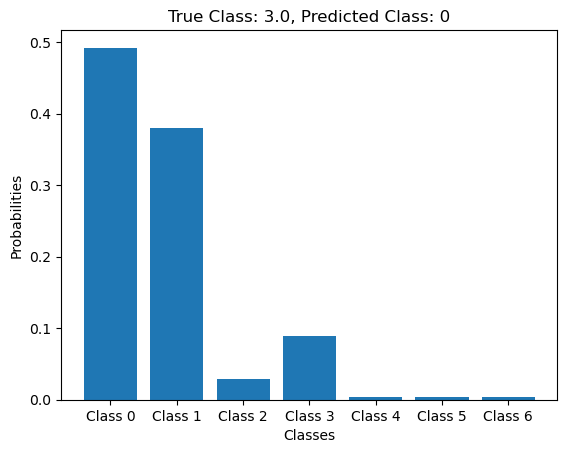

In [12]:
import matplotlib.pyplot as plt

# Assuming 'test_data' contains the test dataset
example_idx = 0  # Change this index to select a specific example
example_inputs, true_class = test_dataset[example_idx]

# Convert example_inputs to a PyTorch tensor
example_inputs = torch.tensor(example_inputs, dtype=torch.float64)

# Convert the model parameters to Double data type
model = classifierModel.double()

model.eval()
with torch.no_grad():
    outputs = model(example_inputs)
    probabilities = torch.softmax(outputs, dim=0)
    predicted_class = torch.argmax(outputs).item()

# Visualize the class probabilities
classes = [f"Class {i}" for i in range(num_of_classes)]
plt.bar(classes, probabilities)
plt.xlabel("Classes")
plt.ylabel("Probabilities")
plt.title(f"True Class: {true_class}, Predicted Class: {predicted_class}")
plt.show()

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


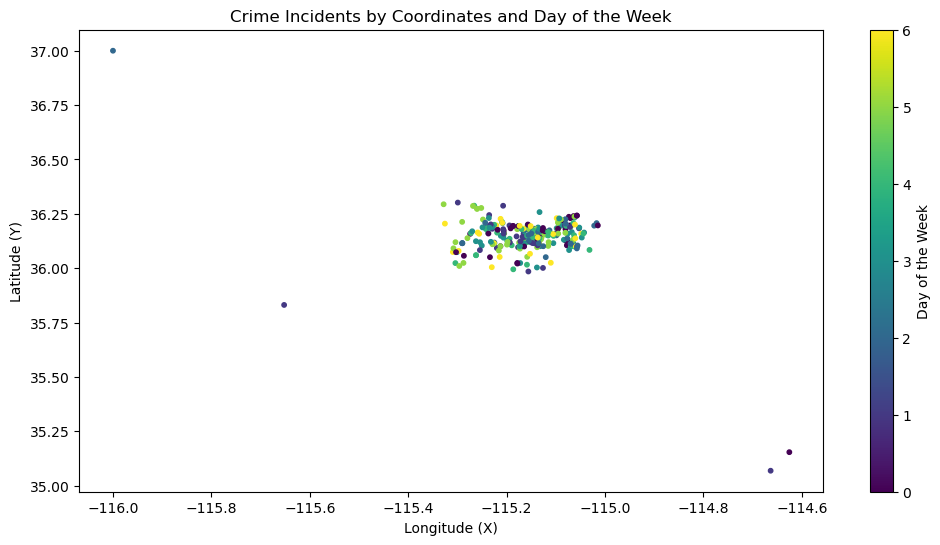

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', s=10)
plt.colorbar(label='Day of the Week')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates and Day of the Week')
plt.show()

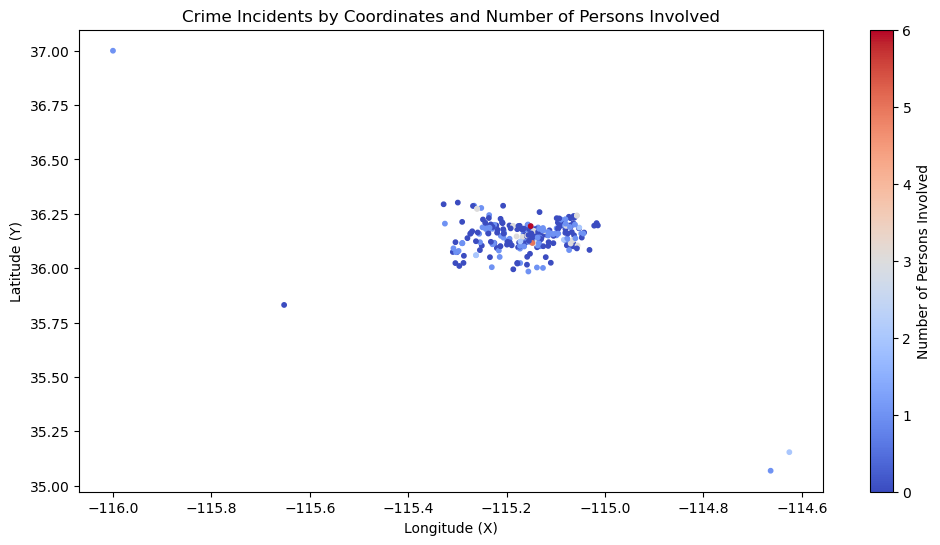

In [14]:
# Scatter plot based on coordinates with number of persons involved as color
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='coolwarm', s=10)
plt.colorbar(label='Number of Persons Involved')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.title('Crime Incidents by Coordinates and Number of Persons Involved')
plt.show()

In [15]:
import numpy as np

# Count the number of crimes reported by day of the week
crime_count_by_day = np.bincount(df['DayOfWeek'])

# Create a dictionary to map day indices to day names
day_mapping = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Create a list of day names sorted by crime count
sorted_days = [(day_mapping[i]+'--->'+str(crime_count_by_day[i])) for i in np.argsort(crime_count_by_day)[::-1]]

# Display the most frequent days
print("Most frequent days for reported crimes:")
for day in sorted_days:
    print(day)

Most frequent days for reported crimes:
Friday--->51
Thursday--->44
Saturday--->43
Monday--->40
Tuesday--->37
Wednesday--->32
Sunday--->28
